In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from scipy.signal import argrelextrema
from collections import deque
from matplotlib.lines import Line2D
from datetime import timedelta

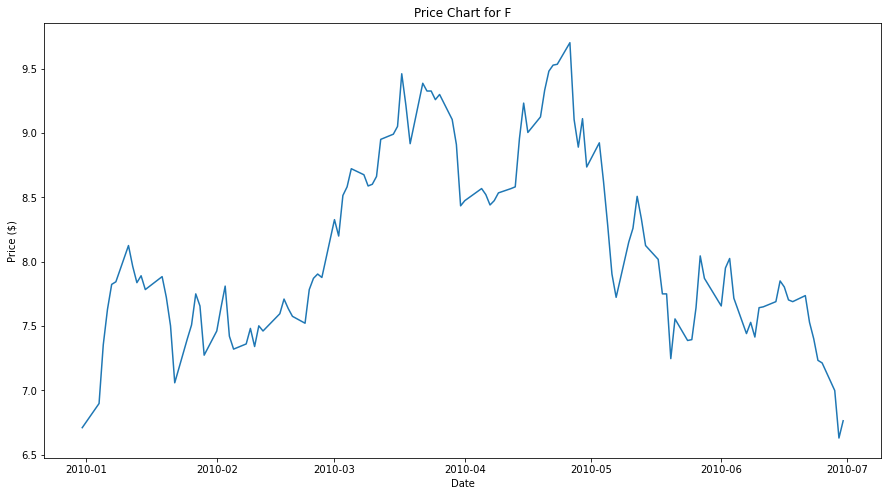

In [3]:
ticker = 'F'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2010-01-01', end='2010-07-01')

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
plt.title(f'Price Chart for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

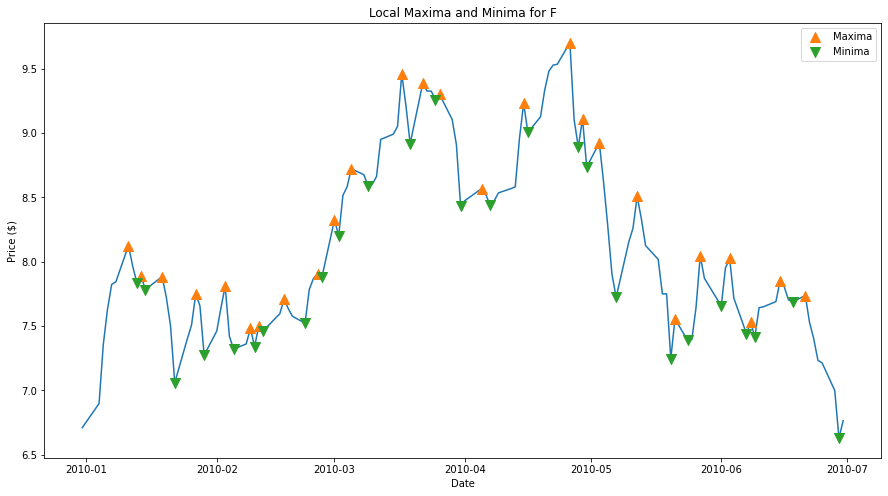

In [4]:
data['local_max'] = data['Close'][
  (data['Close'].shift(1) < data['Close']) &
  (data['Close'].shift(-1) < data['Close'])]

data['local_min'] = data['Close'][
  (data['Close'].shift(1) > data['Close']) &
  (data['Close'].shift(-1) > data['Close'])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.index, data['local_max'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(data.index, data['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima for {ticker}')
plt.legend()
plt.show()

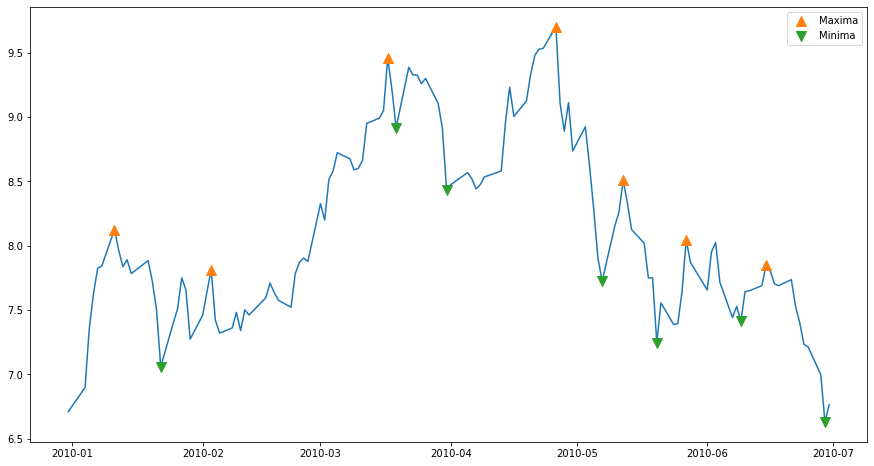

In [5]:
max_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]
min_idx = argrelextrema(data['Close'].values, np.less, order=5)[0]
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['Close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Close'],
  label='Minima', s=100, color=colors[2], marker='v')

plt.legend()
plt.show()

In [7]:
data.iloc[max_idx]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,local_max,local_min
Date,,,,,,,,,
2010-01-11,7.985232,8.146280,7.904709,8.126148,170626200,0,0,8.126148,NaN
2010-02-03,7.710112,7.824187,7.663140,7.810767,90125500,0,0,7.810767,NaN
2010-03-17,9.092427,9.495043,9.092427,9.461493,137318700,0,0,9.461493,NaN
2010-04-26,9.656091,9.776876,9.582278,9.703063,123029200,0,0,9.703063,NaN
2010-05-12,8.434820,8.528764,8.381138,8.508634,102657000,0,0,8.508634,NaN
2010-05-27,7.951683,8.052337,7.824187,8.045627,90700800,0,0,8.045627,NaN
2010-06-15,7.750375,7.891291,7.730244,7.851029,51790900,0,0,7.851029,NaN


In [7]:
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]
highs = data.iloc[high_idx]['Close']

extrema = []
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):
  if i == 0:
    ex_deque.append(idx)
    continue
  if highs[i] < highs[i-1]:
    ex_deque.clear()

  ex_deque.append(idx)
  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())

In [8]:
print(extrema)

[deque([22, 51], maxlen=2), deque([51, 78], maxlen=2)]


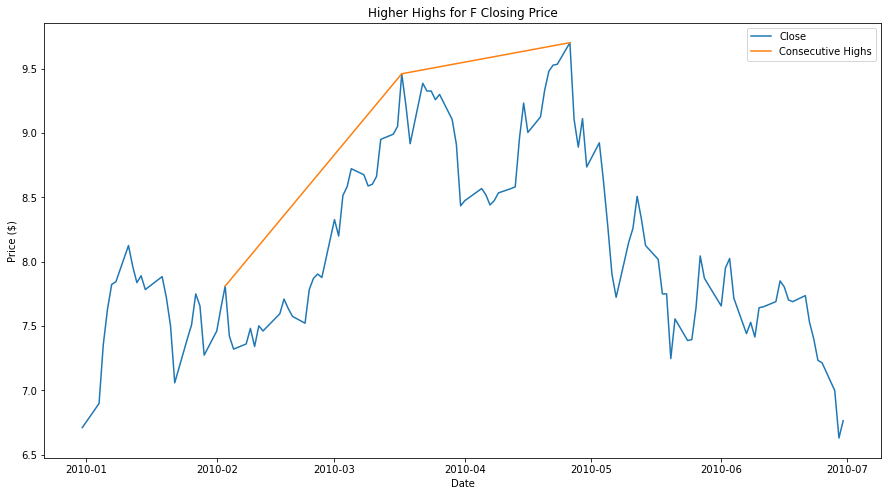

In [9]:
close = data['Close'].values
dates = data.index

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Higher Highs for {ticker} Closing Price')
plt.legend(['Close', 'Consecutive Highs'])
plt.show()

In [12]:
def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

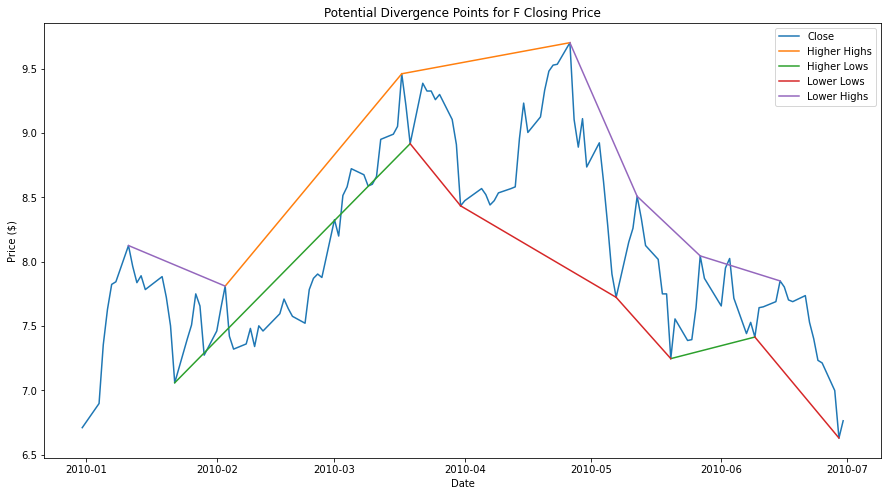

In [15]:
close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color=colors[4], label='Lower Highs')
]
plt.legend(handles=legend_elements)
plt.show()

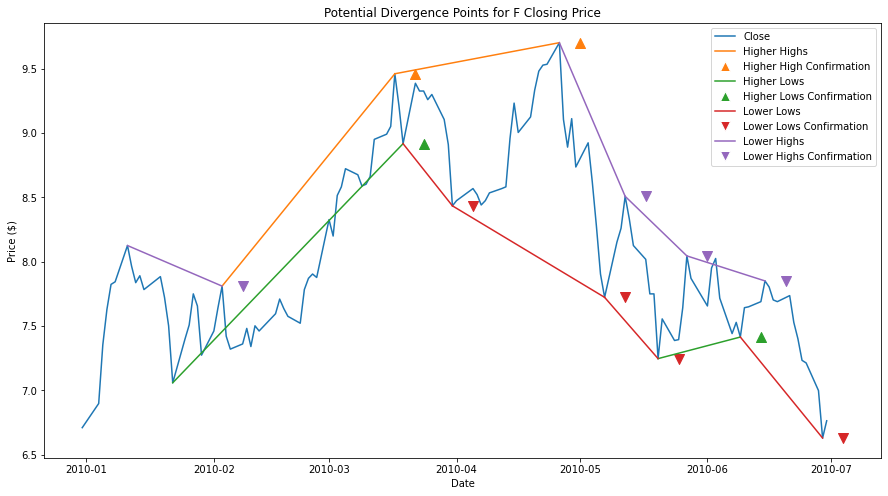

In [18]:
close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]

_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[1], marker='^', s=100) for i in hh]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[2], marker='^', s=100) for i in hl]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[3], marker='v', s=100) for i in ll]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]],
    c=colors[4], marker='v', s=100) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements)
plt.show()